# Novelty and outlier detection

Going through all of the `scikit-learn` methods for outlier detection to see what we get!

## Data

Import the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gower

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc

I deleted three of the missingness indicators (the ones for the variables that are very rarely missing). I also deleted the `source` column, which is TELEAPP only 0.71% of the time.

In [2]:
# Import cleaned data from clean_data.py
df = pd.read_csv('../data/cleaned_Base.csv', index_col=0)

target = 'fraud_bool'
X = df.drop(target, axis = 1)
y = df[target]

# Drop columns we don't want in the model
# Missing flags that the Kaggle guy doesn't use
# source
cols_to_drop = ['current_address_months_count_ismissing',
                'session_length_in_minutes_ismissing',
                'device_distinct_emails_8w_ismissing',
                'source']
X = X.drop(cols_to_drop, axis = 1)

In [3]:
# Print all column names and classes of X
print(X.dtypes)

income                                 float64
name_email_similarity                  float64
current_address_months_count             int64
customer_age                             int64
days_since_request                     float64
payment_type                            object
zip_count_4w                             int64
velocity_6h                            float64
velocity_24h                           float64
velocity_4w                            float64
bank_branch_count_8w                     int64
date_of_birth_distinct_emails_4w         int64
employment_status                       object
credit_risk_score                        int64
email_is_free                            int64
housing_status                          object
phone_home_valid                         int64
phone_mobile_valid                       int64
has_other_cards                          int64
proposed_credit_limit                  float64
foreign_request                          int64
session_lengt

I one-hot encoded 4 of the variables.

For the training set, I filtered to month 0, and then tested on month 1. Based on this, I deleted the month columns.

In [4]:
# Create one-hot encoded version
ohe_cols = ['payment_type', 
            'employment_status', 
            'housing_status', 
            # 'source',
            'device_os']

X_ohe = pd.get_dummies(X, columns=ohe_cols)

# Train on months 0-6
X_ohe_train = X_ohe.loc[X_ohe['month'] < 7]
X_ohe_train = X_ohe_train.drop('month', axis = 1)
print(X_ohe_train.shape)
y_train = y[X_ohe['month'] < 7]

# Test on month 7
X_ohe_test = X_ohe.loc[X_ohe['month'] == 7]
X_ohe_test = X_ohe_test.drop('month', axis = 1)
y_test = y[X_ohe['month'] == 7]

(903157, 48)


In [5]:
X_ohe_train.columns

Index(['income', 'name_email_similarity', 'current_address_months_count',
       'customer_age', 'days_since_request', 'zip_count_4w', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request',
       'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'prev_address_months_count_ismissing',
       'bank_months_count_ismissing', 'intended_balcon_amount_ismissing',
       'payment_type_AA', 'payment_type_AB', 'payment_type_AC',
       'payment_type_AD', 'payment_type_AE', 'employment_status_CA',
       'employment_status_CB', 'employment_status_CC', 'employment_status_CD',
       'employment_status_CE', 'employment_status_CF', 'employment_status_CG',
       'housing_status_BA', 'housing_status_BB', 'housing_status_BC',
       'housing_stat

I also created scaled versions of the training and testing data. I scaled the variables that were neither Boolean, missingness indicators, nor one-hot encoded.

In [6]:
# Create scaled version
scaler = StandardScaler()
# Scale continuous variables
# Excluding ohe_cols, bool_cols, and the _ismissing columns
bool_cols = ['email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session']
cols_to_scale = [col for col in X_ohe_train.columns if 
                 not col.endswith('_ismissing') 
                 and col not in ohe_cols
                 and col not in bool_cols]

# Scale these columns
cont_train_scaled = scaler.fit_transform(X_ohe_train[cols_to_scale])
cont_test_scaled = scaler.transform(X_ohe_test[cols_to_scale])  # Use transform, not fit_transform on test set

# Concatenate scaled and one-hot encoded columns
# Columns to add back in
cols_not_scaled = [col for col in X_ohe_train.columns if col not in cols_to_scale]
X_ohe_train_scaled = np.concatenate((cont_train_scaled, X_ohe_train[cols_not_scaled]), axis = 1)
X_ohe_test_scaled = np.concatenate((cont_test_scaled, X_ohe_test[cols_not_scaled]), axis = 1)

Adding some functions to make the metrics nice (stolen from https://github.com/southworks/machine-learning-unsupervised/blob/main/anomaly-detection/fraud_detection.ipynb).

In [7]:
# Setup functions
# Create a results dataframe to store and later compare results
results = pd.DataFrame()
results['Metrics'] = ['True Negatives', 'False Negatives', 'False Positives', 'True Positives', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support']

def get_metrics(labels, pred_labels):
    conf_matrix = np.asarray(confusion_matrix(labels, pred_labels))
    metrics = np.concatenate(([accuracy_score(labels, pred_labels)], precision_recall_fscore_support(labels, pred_labels, average='binary')))
    return np.concatenate((conf_matrix.reshape(-1),metrics))

def fit_model(input_data, model_fn, model_args=None, threshold=None, labels=None):
    return model_fn(input_data, model_args, threshold, labels)

def predict_model(input_data, model, predict_fn, threshold=None):
    return predict_fn(input_data, model, threshold)

## Isolation forest

Uses decision trees: randomly selects a feature and then randomly selects a split value. Theoretically, outliers will need fewer random partitions to be isolated and thus have a shorter path length on the tree.

- Scale: no
- One-hot encode: yes

I found best performance if I don't specify the contamination level and also don't scale the data.

In [8]:
def fit_isolation_forest(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = IsolationForest(**args)
    else:
        model = IsolationForest(contamination=threshold, **args)
    
    model.fit(input_data)

    return model

def predict_isolation_forest(input_data, model, threshold=None):
    y_pred = model.predict(input_data)
    y_pred = [1 if pred == -1 else 0 for pred in y_pred]

    return y_pred

In [9]:
# Calculate the contamination parameter
contamination_rate = y.sum() / len(y) # going with overall incidence in the data
print("Proportion of fraud in the entire dataset: ", contamination_rate)

Proportion of fraud in the entire dataset:  0.011029


In [10]:
# Run isolation forest on training data
if_model = fit_model(X_ohe_train
                     , fit_isolation_forest
                     , model_args = {'max_features': 1.0,
                                     'n_estimators': 1000}
                    #  , threshold=contamination_rate
                     )

if_pred_test = predict_model(X_ohe_test, if_model, predict_isolation_forest)

print('CONFUSION MATRIX:\n', confusion_matrix(y_test,if_pred_test))
print("Classification Report:\n", classification_report(y_test, if_pred_test))

CONFUSION MATRIX:
 [[78414 17001]
 [ 1083   345]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90     95415
           1       0.02      0.24      0.04      1428

    accuracy                           0.81     96843
   macro avg       0.50      0.53      0.47     96843
weighted avg       0.97      0.81      0.88     96843



In [11]:
results['Isolation Forest'] = get_metrics(y_test, if_pred_test)
results

,Metrics,Isolation Forest
0,True Negatives,78414
1,False Negatives,17001
2,False Positives,1083
3,True Positives,345
4,Accuracy,0.813265
5,Precision,0.019889
6,Recall,0.241597
7,F1-Score,0.036753
8,Support,None


## Local Outlier Factor (LOF)

LOF computes the local density deviation of a given data point with respect to its neighbors. If a point has substantially lower density than its neighbors, it is identified as an outlier.

The contamination parameter sets the proportion of the most isolated points to be predicted as anomalies, so we want to set that to what we believe the incidence of fraud to be.

- Scale: I think so? Gonna do it
- One-hot encode: yes

In [12]:
# LOF model
lof_model = LocalOutlierFactor(n_neighbors = 20, # using the default 
                               contamination = contamination_rate,
                               novelty=False)
# Need to just run it on the testing data and identify the outliers there
lof_pred_test = lof_model.fit_predict(X_ohe_test_scaled)
# Try just on first 10000 rows to compare to Gower
# lof_pred_test = lof_model.fit_predict(X_ohe_train_scaled[0:10000,:])

In [13]:
# np.unique(lof_pred_train, return_counts = True)
# Recode the predictions
lof_pred_test[lof_pred_test == 1] = 0
lof_pred_test[lof_pred_test == -1] = 1

print('CLASSIFICATION RESULTS')
print(classification_report(y_test, lof_pred_test))

CLASSIFICATION RESULTS
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     95415
           1       0.02      0.02      0.02      1428

    accuracy                           0.97     96843
   macro avg       0.50      0.50      0.50     96843
weighted avg       0.97      0.97      0.97     96843



In [14]:
results['LOF'] = get_metrics(y_test, lof_pred_test)
results

,Metrics,Isolation Forest,LOF
0,True Negatives,78414,94370
1,False Negatives,17001,1045
2,False Positives,1083,1404
3,True Positives,345,24
4,Accuracy,0.813265,0.974712
5,Precision,0.019889,0.022451
6,Recall,0.241597,0.016807
7,F1-Score,0.036753,0.019223
8,Support,None,None


### With Gower distance

Using the built-in distance metrics for LOF doesn't really make a lot of sense because unfortunately we have a mix of continous and categorical variables. Can we use Gower distance instead?

In [15]:
# Just do first 10000 rows because we have to do a big distance matrix
X_0 = X.head(10000)
X_0 = X_0.drop('month', axis=1)
y_0 = y.head(10000)

# List the categorical columns
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
# Add boolean columns and missingness indicators
cat_cols = cat_cols + bool_cols + [col for col in X.columns if col.endswith('_ismissing')]
cat_cols

['payment_type',
 'employment_status',
 'housing_status',
 'device_os',
 'email_is_free',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'foreign_request',
 'keep_alive_session',
 'prev_address_months_count_ismissing',
 'bank_months_count_ismissing',
 'intended_balcon_amount_ismissing']

In [16]:
gower_dist_0 = gower.gower_matrix(X_0, cat_features=[col in cat_cols for col in X_0.columns])

In [17]:
# LOF model
lof_gower = LocalOutlierFactor(n_neighbors = 20, 
                               contamination = contamination_rate,
                               novelty=False,
                               metric='precomputed')
# Need to just run it on the testing data and identify the outliers there
lof_pred_gower = lof_gower.fit_predict(gower_dist_0)

In [18]:
# Recode the predictions
lof_pred_gower[lof_pred_gower == 1] = 0
lof_pred_gower[lof_pred_gower == -1] = 1

print('CLASSIFICATION RESULTS')
print(classification_report(y_0, lof_pred_gower))

CLASSIFICATION RESULTS
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9895
           1       0.02      0.02      0.02       105

    accuracy                           0.98     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.98      0.98      0.98     10000



In [19]:
results['LOF Gower'] = get_metrics(y_0, lof_pred_gower)
results

,Metrics,Isolation Forest,LOF,LOF Gower
0,True Negatives,78414,94370,9786
1,False Negatives,17001,1045,109
2,False Positives,1083,1404,103
3,True Positives,345,24,2
4,Accuracy,0.813265,0.974712,0.9788
5,Precision,0.019889,0.022451,0.018018
6,Recall,0.241597,0.016807,0.019048
7,F1-Score,0.036753,0.019223,0.018519
8,Support,None,None,None


## Gaussian Mixture

Gaussian mixture models assume all data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. They try to find different subpopulations within the overall dataset.

- Scale: eh why not
- One-hot encode: yea

In [20]:
# def fit_gaussian_mixture(input_data, args=None, threshold=None, labels=None):
#     if threshold == None:
#         model = GaussianMixture(n_components=2)
#     else:
#         model = GaussianMixture(n_components=2, reg_covar=threshold)
    
#     model.fit(input_data)

#     return model

# def predict_gaussian_mixture(input_data, model, threshold=None):
#     return model.predict(input_data)

In [21]:
# gmm = GaussianMixture(n_components=1)
# gmm.fit(X_ohe_train_scaled)

# # Compute log-likelihood on test data
# gm_loglikelihood = gmm.score_samples(X_ohe_test_scaled)

# # Set threshold
# ll_threshold = np.percentile(gm_loglikelihood, 100 * contamination_rate)

# gm_pred_test = gm_loglikelihood < ll_threshold
# print('CONFUSION MATRIX:\n', confusion_matrix(y_test,gm_pred_test))
# print("Classification Report:\n", classification_report(y_test, gm_pred_test))

In [22]:
# results['Gaussian Mixture'] = get_metrics(y_test, gm_pred_test)
# results

## ROC curve

I want to plot ROC curves for both methods and compare.

In [23]:
# Get the prediction scores
if_scores = -if_model.decision_function(X_ohe_test)  # For Isolation Forest, the anomaly score is defined as -decision_function
lof_scores = -lof_model.negative_outlier_factor_  # For LOF, the anomaly score is defined as -negative_outlier_factor_

# Compute ROC curve for Isolation Forest
fpr_if, tpr_if, _ = roc_curve(y_test, if_scores)
roc_auc_if = auc(fpr_if, tpr_if)

# Compute ROC curve for LOF
fpr_lof, tpr_lof, _ = roc_curve(y_test, lof_scores)
roc_auc_lof = auc(fpr_lof, tpr_lof)



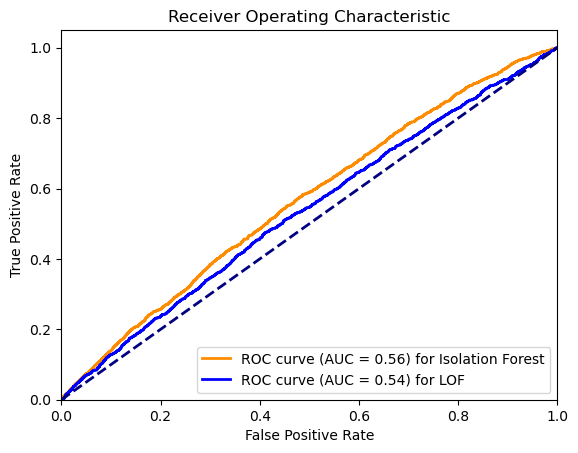

In [25]:
plt.figure()
lw = 2
plt.plot(fpr_if, tpr_if, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f) for Isolation Forest' % roc_auc_if)
plt.plot(fpr_lof, tpr_lof, color='blue',
         lw=lw, label='ROC curve (AUC = %0.2f) for LOF' % roc_auc_lof)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()